In [2]:
import numpy as np
import matplotlib.pyplot as plt
from data_load import load_data, pmumu, nll, lam_i, parabolic, nll_dm2, nll_theta, deltaNLL, curv_method

data, flux = load_data()

In [3]:
dm2 = 0.002498086689393643
theta = 0.677357495428374


E_bin = np.linspace(0, 10, 200, endpoint = False) 
dE = 10.0 / 200.0  

E = E_bin + dE*0.5
N = lam_i(theta, dm2)

In [4]:
def gaussianconv(E, N, mu, sigma):
    E = np.asarray(E, float)
    N = np.asarray(N, float)

    if sigma <= 0:      # no smearing case
        return E, N.copy()

    dE = E[1] - E[0]
    pad = int(np.ceil(6.0 * sigma / dE))

     # padding the energy axis so energy grid extends beyond 10GeV and tails arent cut
    E_pad = np.concatenate([E[0] + dE*np.arange(-pad, 0),E,E[-1] + dE*np.arange(1, pad+1)])  
    N_pad = np.concatenate([np.zeros(pad), N, np.zeros(pad)])

    # construct Gaussian response matrix
    diff = E_pad[:, None] - (E_pad[None, :] + mu)
    G = np.exp(-0.5 * (diff / sigma)**2)

    G /= G.sum(axis=0, keepdims=True)   # normalise

    # apply convolution
    N_recon_pad = G @ N_pad
    N_recon = N_recon_pad[pad:pad + len(E)]
    N_recon *= N.sum()/N_recon.sum()
    return E, N_recon

In [5]:
def nlltotal(theta, dm2, mu, sigma):
    """"
    NLL including detector smearing.
    Uses existing lam_i(theta, dm2) for the true spectrum.
    """
    # addnlls_minusting for unphysical sigma
    if sigma <= 0:
        return nll(theta, dm2)

    # true prediciton
    lam = lam_i(theta, dm2) 

    # smear with Gaussian response
    E_recon, lam_smear = gaussianconv(E, lam, mu, sigma)
    lam_smear = np.where(lam_smear<=0, 1e-12, lam_smear)
    return 2.0 * np.sum(lam_smear - data * np.log(lam_smear))

In [6]:
test=nlltotal(theta, dm2, 0, 0)
print(test)

-84.74436319084403


In [7]:
print('NLL no detector: ', nll(theta, dm2))
print('NLL with detector:', nlltotal(theta, dm2, mu= -0, sigma = 0))

# matches --> consistent, continue with calculation. 

NLL no detector:  -84.74436319084403
NLL with detector: -84.74436319084403


In [8]:
# 2D coarse grid scan for mu and sigma 

mu_vals    = np.linspace(-1, 1, 50)
sigma_vals = np.linspace(0, 2, 50)  

best_nll = None

for m in mu_vals:
    for s in sigma_vals:
        val1 = nlltotal(theta, dm2, m, s)
        if (best_nll is None) or (val1 < best_nll):
            best_nll = val1
            best_mu     = m
            best_sigma  = s

print(f'mu = {best_mu:.3f} GeV')
print(f'sigma = {best_sigma:.3f} GeV')
print(f'NLL = {best_nll:.3f}')

mu = -0.061 GeV
sigma = 0.367 GeV
NLL = -178.634


In [9]:
print(best_nll - test)

lam_true = lam_i(theta, dm2)
E, lam_smear = gaussianconv(E, lam_true, best_mu, best_sigma)

print(lam_true.sum(), lam_smear.sum())

-93.88990205859135
377.2797125670294 377.27971256702943


In [10]:
theta_vals = np.linspace(theta - 0.1, theta + 0.1, 50)
dm2_vals   = np.linspace(dm2 - 1e-3, dm2 + 1e-3, 50)

best_nll = None
for t in theta_vals:
    for d in dm2_vals:
        val = nlltotal(t, d, best_mu, best_sigma)
        if (best_nll is None) or (val < best_nll):
            best_nll= val
            best_theta    = t
            best_dm2      = d

print(f'theta  = {best_theta:.6f} rad')
print(f'dm2    = {best_dm2:.6e} eV^2')
print(f'mu     = {best_mu:.3f} GeV')
print(f'sigma  = {best_sigma:.3f} GeV')
print(f'NLL    = {best_nll:.3f}')

theta  = 0.695725 rad
dm2    = 2.518495e-03 eV^2
mu     = -0.061 GeV
sigma  = 0.367 GeV
NLL    = -179.243


In [11]:
print(f'NLL no detector:  {nll(best_theta, best_dm2)}')
print(f'NLL with detector: {nlltotal(best_theta, best_dm2, best_mu, best_sigma)}')
print(f'NLL with detector, base values: {nlltotal(best_theta, best_dm2, 0, 0)}')

NLL no detector:  -80.17314554032058
NLL with detector: -179.24348691868164
NLL with detector, base values: -80.17314554032058


In [12]:
print(best_nll - test)

lam_true = lam_i(theta, dm2)
E, lam_smear = gaussianconv(E, lam_true, best_mu, best_sigma)

print(lam_true.sum(), lam_smear.sum())

-94.49912372783761
377.2797125670294 377.27971256702943


In [13]:
# 4D fit - very dnlls_minank
theta_vals = np.linspace(best_theta - 0.05, best_theta + 0.05, 11)
dm2_vals   = np.linspace(best_dm2 - 0.1e-3, best_dm2 + 0.1e-3, 11)
mu_vals    = np.linspace(best_mu - 0.01, best_mu + 0.01, 11)
sigma_vals = np.linspace(best_sigma - 0.01, best_sigma + 0.01, 11)

best_nll   = None


for t in theta_vals:
    for d in dm2_vals:
        for m in mu_vals:
            for s in sigma_vals:
                v = nlltotal(t, d, m, s)
                if (best_nll is None) or (v < best_nll):
                    best_nll  = v
                    best_theta = t
                    best_dm2 = d
                    best_mu = m
                    best_sigma = s

In [14]:
print(best_theta,best_dm2,best_mu, best_sigma)
lam_true = lam_i(best_theta, best_dm2)
E, lam_smear = gaussianconv(E, lam_true, best_mu, best_sigma)

print(lam_true.sum(), lam_smear.sum())
print(lam_true.sum()/lam_smear.sum())

0.6957248423671495 0.002518494852658949 -0.05122448979591843 0.35734693877551016
365.45701800265516 365.45701800265516
1.0


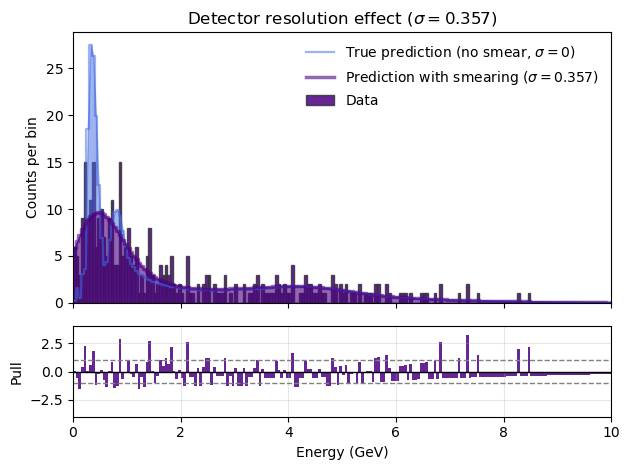

In [25]:
pulls = (data - lam_smear) / np.sqrt(lam_smear)

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True,gridspec_kw={'height_ratios': [3, 1]})

ax1.bar(E, data,width=0.05, edgecolor='0.2',color='indigo',alpha=0.85,label='Data')

ax1.step(E, lam_true,where='mid',label='True prediction (no smear, $\sigma=0$)',alpha=0.5,linewidth=1.6,color='royalblue')

ax1.step(E, lam_smear,where='mid',label=f'Prediction with smearing ($\sigma={best_sigma:.3f}$)',alpha=0.6,linewidth=2.5,color='indigo')

ax1.fill_between(E,np.minimum(lam_true, lam_smear),lam_true,alpha=0.5,color='royalblue')

ax1.fill_between(E,0,lam_smear,alpha=0.6,color='indigo')

ax1.set_ylabel('Counts per bin')
ax1.set_title(f'Detector resolution effect ($\sigma={best_sigma:.3f}$)')
ax1.legend(frameon=False)

ax2.axhline(0, color='k', linewidth=1)
ax2.axhline(1, color='grey', linestyle='--', linewidth=1)
ax2.axhline(-1, color='grey', linestyle='--', linewidth=1)

ax2.bar(E, pulls,width=0.05,color='indigo',alpha=0.85)

ax2.set_xlabel('Energy (GeV)')
ax2.set_ylabel('Pull')
ax2.set_ylim(-4, 4)
ax2.set_xlim(0,10)
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()
plt.close()

In [33]:
chi2 = np.sum((data - lam_smear)**2 / lam_smear)
dof = len(data) - 4 
print(f'chi2/dof = {chi2/dof:.2f}')

mean_pull = np.mean(pulls)
rms_pull  = np.sqrt(np.mean(pulls**2))
print(mean_pull, rms_pull)

chi2_true = np.sum((data - lam_true)**2 / lam_true)
dof = len(data) - 2 
print(f'chi2/dof = {chi2_true/dof:.2f}')
pulls_true = (data - lam_true) / np.sqrt(lam_true)
mean_pull_true = np.mean(pulls_true)
rms_pull_true  = np.sqrt(np.mean(pulls_true**2))
print(mean_pull_true, rms_pull_true)

chi2/dof = 0.83
-0.11110421794582491 0.9042541161291381
chi2/dof = 2.23
0.06699444350909622 1.485160881021599


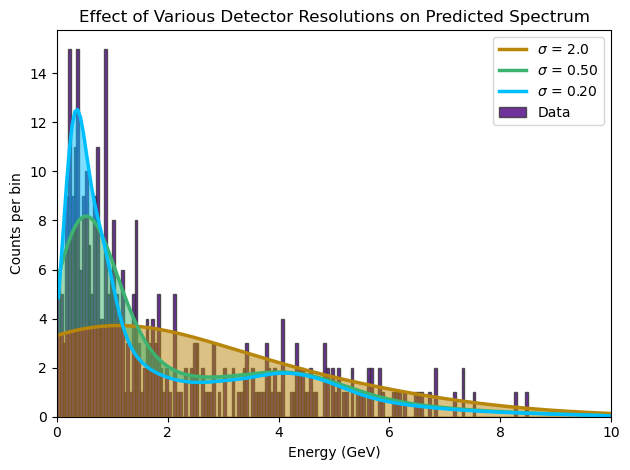

In [26]:
plt.bar(E, data, width=0.05, edgecolor='0.2', color = 'indigo', alpha = 0.8, label = 'Data')
E, lam_sm1 = gaussianconv(E, lam_true, best_mu, 2)
plt.plot(E, lam_sm1, linewidth=2.5, label= '$\sigma$ = 2.0', color = 'darkgoldenrod')
E, lam_sm2 = gaussianconv(E, lam_true, best_mu, 0.5)
plt.plot(E, lam_sm2, linewidth=2.5, label= '$\sigma$ = 0.50', color = 'mediumseagreen')
E, lam_sm3 = gaussianconv(E, lam_true, best_mu, 0.2)
plt.plot(E, lam_sm3, linewidth=2.5, label= '$\sigma$ = 0.20', color='deepskyblue')


plt.fill_between(E, 0, lam_sm1, alpha = 0.5, color = 'darkgoldenrod')
plt.fill_between(E, np.minimum(lam_sm3, lam_sm1), lam_sm2, alpha = 0.5, color = 'mediumseagreen')
plt.fill_between(E, np.minimum(lam_sm2, lam_sm3), lam_sm3, alpha = 0.5, color = 'deepskyblue')

plt.xlabel('Energy (GeV)')
plt.ylabel('Counts per bin')
plt.title('Effect of Various Detector Resolutions on Predicted Spectrum')
plt.legend()
plt.xlim(0,10)
plt.tight_layout()
plt.show()
plt.close()

In [17]:
sigma_vals = np.linspace(0.1, 0.6, 80)
nll_vals = []
for s in sigma_vals:
    nll_vals.append(nlltotal(best_theta, best_dm2, best_mu, s))

# could use polyfit, but playing it #safe 
y0 = nll_vals[np.argmin(nll_vals)-1]
y1 = nll_vals[np.argmin(nll_vals)]
y2 = nll_vals[np.argmin(nll_vals)+1]
sigma_refined = sigma_vals[np.argmin(nll_vals)] + 0.5*(sigma_vals[1] - sigma_vals[0])*(y0 - y2)/(y0 - 2*y1 + y2)

nll_vals = np.array(nll_vals)
delta_nll_vals = nll_vals -np.min(nll_vals)

dnlls_min =  np.argmin(delta_nll_vals)

# left
while  dnlls_min > 0 and delta_nll_vals[dnlls_min] < 1.0:
    dnlls_min  -= 1
sigL = sigma_vals[dnlls_min ] + (1.0 - delta_nll_vals[dnlls_min ]) *(sigma_vals[dnlls_min +1] - 
        sigma_vals[dnlls_min]) / (delta_nll_vals[dnlls_min +1] - delta_nll_vals[dnlls_min ])

# right
dnlls_min =  np.argmin(delta_nll_vals)
while dnlls_min < len(delta_nll_vals)-1 and delta_nll_vals[dnlls_min] < 1.0:
    dnlls_min += 1
sigR = sigma_vals[dnlls_min-1] + (1.0 - delta_nll_vals[dnlls_min-1]) * (sigma_vals[dnlls_min] - 
        sigma_vals[dnlls_min-1]) /(delta_nll_vals[dnlls_min] - delta_nll_vals[dnlls_min-1])

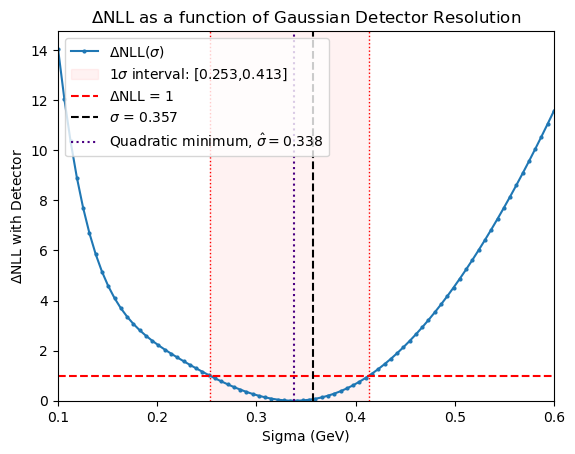

0.33791003669363845


In [18]:
plt.plot(sigma_vals, delta_nll_vals, marker='o', markersize=2, label = '$\Delta$NLL$(\sigma)$')
plt.xlabel('Sigma (GeV)')
plt.ylabel('$\Delta$NLL with Detector')

plt.axvline(sigL, color='red', linestyle=':', linewidth=1)
plt.axvline(sigR, color='red', linestyle=':', linewidth=1)
plt.axvspan(sigL, sigR, alpha=0.05, color='red', label=f'$1\sigma$ interval: [{sigL:.3f},{sigR:.3f}]')

plt.axhline(1.0, linestyle = '--', color = 'red', label = '$\Delta$NLL = 1')
plt.axvline(best_sigma, linestyle = '--', color = 'black', label =f'$\sigma$ = {best_sigma:.3f}')
plt.axvline(sigma_refined, linestyle = ':', color = 'indigo', label ='Quadratic minimum, $\hat{\sigma}=0.338$' )
plt.ylim(0)
plt.xlim(np.min(sigma_vals), np.max(sigma_vals))
plt.title('$\Delta$NLL as a function of Gaussian Detector Resolution')
plt.legend(loc='upper left')

plt.show()
plt.close()
print(sigma_refined)